In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

ModuleNotFoundError: No module named 'torchvision'

In [3]:

# while we could pad the first tau sequences with zeros, to keep things simple, we drop them for now.
# the resulting datasets containing T-tau examples, where each input into the model has sequence length tau
# T=1000
# yt   xt          Xt=[xt-tao,xt-1](for prediction）
tau = 4              #  为什么特征的形状是T-tau*tau

# 因为对于每一个时间点来说，可以用来预测它的是tau个样本点
# T长度的序列，倒数T-tau个是可以预测的，因为前tau个没有足够tau的样本点
features = torch.zeros((T - tau, tau))# feature matrix  initialized to zeros, with size (996,4)
for i in range(tau):
    features[:, i] = x[i: T - tau + i]  # 从前到后
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练          # 对列索引
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [4]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:# # 如果层的类型是线性层
        nn.init.xavier_uniform_(m.weight)# 使用 Xavier 均匀分布初始化权重

# 一个简单的多层感知机
def get_net():# # 定义获取网络的函数
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)#  # 对网络的每一层应用权重初始化函数
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [5]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.067157
epoch 2, loss: 0.056266
epoch 3, loss: 0.054015
epoch 4, loss: 0.055921
epoch 5, loss: 0.053203


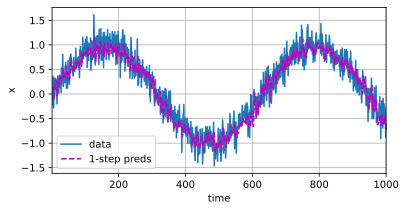

In [6]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

         

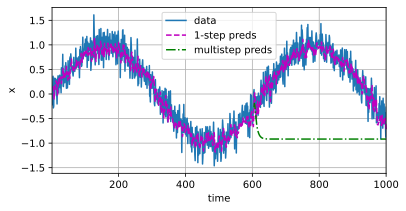

In [7]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))
# 从600开始向后面预测400个点  绿色的是迭代    误差累积   短期预测行 长期预测不行
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

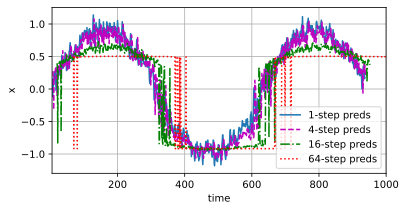

In [8]:
max_steps = 64
######尽可能去预测远的未来
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))